In [605]:
import pandas as pd
#import requests
#from bs4 import BeautifulSoup as bs
import selenium
import ssl
import urllib3
from datetime import datetime
import matplotlib.pyplot as plt

import numpy as np


from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.keys import Keys

from selenium.webdriver.common.action_chains import ActionChains

from selenium.webdriver.support.ui import Select
import time

## Functions

In [259]:
def start_driver(url):
    driver = webdriver.Edge()
    driver.get(url)
    
    # Wait until the page is fully loaded
    wait = WebDriverWait(driver, 100)  # Adjust the timeout value as needed
    wait.until(EC.presence_of_element_located((By.TAG_NAME, 'body')))
    return driver

In [267]:
def player_search(driver, player_str):
    # Search for Player
    search_bar_xpath = '//input[@id="search-for-players"]'
    search_bar_element = driver.find_element(By.XPATH, search_bar_xpath)
    search_bar_element.send_keys(player_str)
    search_bar_element.send_keys(Keys.RETURN)
    wait = WebDriverWait(driver, 100)
    wait.until(EC.presence_of_element_located((By.TAG_NAME, 'body')))

In [274]:
def change_game_log_year(driver, year):
    # Change Year of Game Log
    selected_tab_xpath = '//div[@class="filter-tab is-selected"]'
    selected_tab_element = driver.find_element(By.XPATH, selected_tab_xpath)
    if selected_tab_element.text != str(year):  
        year_tabs_xpath = '//div[@class="filter-tab"]'
        year_tabs_elements = driver.find_elements(By.XPATH, year_tabs_xpath)
        chosen_year_xpath = f'//div[@data-name="{str(year)}"]'
        for element in year_tabs_elements:
            if element.text == str(year):
                selected_tab_element = element
                break
                
    driver.execute_script("arguments[0].scrollIntoView();", selected_tab_element)
    selected_tab_element.click()
    #search_bar_element.send_keys(player_str)
    #search_bar_element.send_keys(Keys.RETURN)
    #wait.until(EC.presence_of_element_located((By.TAG_NAME, 'body')))

In [680]:
def get_game_log_table(driver):
    # Find Game Log Table
    table_xpath = f'//div[@id="gamelog-{str(year)}-stats"]'
    game_log_element = driver.find_element(By.XPATH, table_xpath)
    table_xpath = './/div[@role="grid"]'
    wait = WebDriverWait(driver, 100)  # Adjust the timeout value as needed
    wait.until(EC.presence_of_element_located((By.XPATH, table_xpath)))
    game_log_element = game_log_element.find_element(By.XPATH, table_xpath)
    return game_log_element

In [603]:
def scroll_left(game_log_element):
    scrollable_xpath = './/div[@role="scrollbar"]'
    scrollable_element = game_log_element.find_element(By.XPATH, scrollable_xpath)
    
    # Scroll the element to the left using JavaScript
    #driver.execute_script("arguments[0].scrollIntoView();", scrollable_element)
    driver.execute_script("arguments[0].scrollLeft -= 500;", scrollable_element)

def scroll_right(game_log_element):
    scrollable_xpath = './/div[@role="scrollbar"]'
    scrollable_element = game_log_element.find_element(By.XPATH, scrollable_xpath)
    
    # Scroll the element to the right using JavaScript
    #driver.execute_script("arguments[0].scrollIntoView();", scrollable_element)
    driver.execute_script("arguments[0].scrollLeft += 500;", scrollable_element)

In [831]:
def get_game_log_header(game_log_element):
    #header_xpath = './/div[@class="webix_ss_center"]'
    #header_element = game_log_element.find_element(By.XPATH, header_xpath)
    header_rows = game_log_element.find_elements(By.XPATH, './/tr[@section="header" and @role="row"]')
    header_cells_top = header_rows[2].find_elements(By.XPATH,'.//td[@column]')
    header_cells_bottom = header_rows[3].find_elements(By.XPATH,'.//td[@column]')

    header_top_list = []
    header_top_col_nums = []
    for cell in header_cells_top:
        if len(cell.text.strip()) > 0:
            header_top_list.append(cell.text.strip())
            header_top_col_nums.append(int(cell.get_attribute("column")))

    
    header_top_df = pd.DataFrame(dict(col_nums=header_top_col_nums, col_names=header_top_list)).set_index('col_nums')
    header_top_df = header_top_df[::-1]
    #display(header_top_df)
    
    header_list = []
    header_col_nums = []
    header_number = header_top_col_nums[-1]
    for cell in header_cells_bottom[::-1]:
        i = int(cell.get_attribute("column"))
        #print(i)
        if len(cell.text.strip()) > 0:
            if i in header_top_col_nums:
                header_number = i
                #print(header_number)
            new_header = (header_top_df.loc[header_number][0], cell.text.strip())
            #print(new_header)
            header_list.append(new_header)
            header_col_nums.append(i)

    first_two_headers = [('Games', 'Week'), ('Games', 'Opponent')]
    
    header_list = first_two_headers + header_list[::-1]
    header_col_nums = [0, 1] + header_col_nums[::-1]
    #print(header_list)
    #print(header_col_nums)
    
    return pd.DataFrame(dict(col_num = header_col_nums, col_names = header_list))

In [829]:
def get_dnp_weeks(game_log_element):
    # Get the index of the row with 'BYE'
    game_columns = game_log_element.find_element(By.XPATH, './/div[@column="1"]').text.split('\n')
    #print(game_columns)
    bye_index = game_columns.index('BYE')
    # Get index of other weeks where they didn't play
    snap_column = game_log_element.find_element(By.XPATH, './/div[@column="4"]').text.split('\n')
    snap_column.insert(bye_index, 'BYE')
    #print(snap_column)
    dnp_weeks = [i for i, x in enumerate(snap_column) if x == 'DNP']
    dnp_weeks.append(bye_index)
    dnp_weeks.sort()
    #print(dnp_weeks)
    return dnp_weeks

In [825]:
def get_game_log_data(game_log_element, col_names, year, dnp_weeks):
    col_names = col_names.set_index('col_num')
    bye_index = None
    columns_xpath = './/div[@column]'
    columns_elements = game_log_element.find_elements(By.XPATH, columns_xpath)
    
    
    #cells_xpath = './/div[@role="gridcell"]'
    df = pd.DataFrame()
    
    
    for column in columns_elements:
        #column_list = []
        #gridcell_elements = game_log_element.find_elements(By.XPATH, cells_xpath)
        #for cell in gridcell_elements:
        #    column_list.append(cell.text)
        # Get text for column
        i = int(column.get_attribute("column"))
        tmp = column.text
        tmp = tmp.split('\n')
        tmp = [x for x in tmp if x != 'DNP']


        # Delete on DNP rows:
        if i >= 1:
            if len(tmp) > len(df):
                for index in dnp_weeks[::-1]:
                    del tmp[int(index)]

        # Get rid of bye week row if column includes it
        #if bye_index:
        #    if len(tmp) > len(df):
        #        if len(tmp) != 0:
        #             tmp = tmp.drop(bye_index)

        # Add column to main dataframe
        if i == 0:
            df[('Games','Year')] = [year] * len(tmp)
        df[col_names.loc[i][0]] = pd.Series(tmp)

        # Remove bye row and find bye index
        #if i == 1:
        #    rows_with_bye = df[df[col_names[i]].str.contains('BYE')]

            # Get the index of the row with 'BYE'
        #    bye_index = rows_with_bye.index.tolist()[0]

            # Delete BYE row
        #    df = df[~df[col_names[i]].str.contains('BYE')].reset_index(drop = True)
        if i == 1:
            df = df.drop(dnp_weeks).reset_index(drop=True)

    df.columns = pd.MultiIndex.from_tuples(df.columns)
    return df



## Get Data

In [1068]:
rotowire_url = f'https://www.rotowire.com/'
player_str = 'Jalen Hurts'

driver = start_driver(rotowire_url)
player_search(driver, player_str)

In [1069]:
all_games_df = pd.DataFrame()
for year in [2021,2022,2023,2024]:
    print(year)
    change_game_log_year(driver, year)
    game_log_element = get_game_log_table(driver)
    time.sleep(1)
    scroll_left(game_log_element)
    time.sleep(1)
    headers = get_game_log_header(game_log_element)
    dnp_weeks = get_dnp_weeks(game_log_element)
    game_log_df = get_game_log_data(game_log_element, headers, year, dnp_weeks)
    time.sleep(1)
    scroll_right(game_log_element)
    time.sleep(1)
    headers_2 = get_game_log_header(game_log_element)
    game_log_df_2 = get_game_log_data(game_log_element, headers_2, year, dnp_weeks)
    game_log_df_2 = game_log_df_2.drop(list(set(game_log_df.columns).intersection(set(game_log_df_2.columns))), axis = 1)
    game_log_df_combined = pd.concat([game_log_df, game_log_df_2], axis=1).fillna(0)
    game_log_df_combined[('Games','Year')] = year
    all_games_df = pd.concat([all_games_df, game_log_df_combined]).reset_index(drop = True)

driver.close()

all_games_df = all_games_df.replace('–',0)

2021
2022
2023
2024


In [1070]:

ypc_col = all_games_df[('Rushing', 'YDS')].astype(int) / all_games_df[('Rushing', 'ATT')].astype(int)
ypc_col_index = all_games_df.columns.get_loc(('Rushing', 'ATT')) + 1
all_games_df.insert(ypc_col_index, [('Rushing', 'YPC')], ypc_col)

TypeError: unhashable type: 'list'

In [1071]:
last_game_played = [2024, 2]
cutoff_index = all_games_df[(all_games_df.Games.Year == last_game_played[0]) & (all_games_df.Games.Week == str(last_game_played[1]))].index[0]
past_games_df = all_games_df[:cutoff_index+1]

In [1072]:
playoffs_bool = (past_games_df.Games.Week != 'WC') & (past_games_df.Games.Week != 'DIV') & (past_games_df.Games.Week != 'CC') & (past_games_df.Games.Week != 'SB')

reg_szn_games_df = past_games_df[playoffs_bool].reset_index(drop = True)

## Analysis

In [1076]:
selected_column = ('Passing', 'YDS')

In [1077]:
def get_moving_avg(series, window):
    return series.rolling(window).mean()

moving_avg = get_moving_avg(reg_szn_games_df[selected_column], 4)

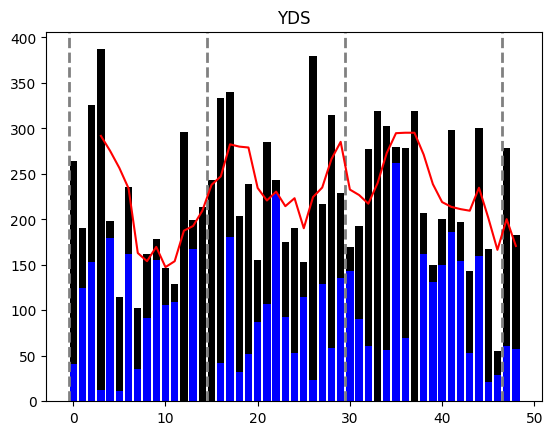

In [1086]:
matchups = 1 - reg_szn_games_df['Opp Rank'].iloc[:, 0].astype(int) / 32

def get_moving_avg(series, window):
    return series.rolling(window).mean()

moving_avg = get_moving_avg(reg_szn_games_df[selected_column], 4)

new_season_bool = reg_szn_games_df.Games.Week == "1" 
new_season = list(reg_szn_games_df.index[list(new_season_bool)])
for year_index in new_season:  
    plt.axvline(x = year_index-0.5, color='grey', linestyle='--', linewidth=2)
plt.bar(reg_szn_games_df.index, reg_szn_games_df[selected_column].astype(float), color='black')
plt.bar(reg_szn_games_df.index, matchups*reg_szn_games_df[selected_column].astype(float), color='blue')
plt.plot(reg_szn_games_df.index, moving_avg, color = 'red')
plt.title(selected_column[1])
plt.show()

In [1085]:
new_season_bool

[0, 15, 30, 47]

In [1084]:
reg_szn_games_df

Games               Opp Rank Fantasy Snaps    Passing            ...  \
    Year Week Opponent    vs QB  Points   OFF ST    COMP ATT   PCT  ...   
0   2021    1     @ATL       27    31.4    72  0      27  35  77.1  ...   
1   2021    2       SF       11    23.7    55  0      12  23  52.2  ...   
2   2021    3     @DAL       17    27.8    53  0      25  39  64.1  ...   
3   2021    4       KC       31    32.1    70  0      32  48  66.7  ...   
4   2021    5     @CAR        3    24.9    61  0      22  37  59.5  ...   
5   2021    6       TB       29    26.2    47  0      12  26  46.2  ...   
6   2021    7      @LV       10    25.9    68  0      18  34  52.9  ...   
7   2021    8     @DET       21    12.3    48  0       9  14  64.3  ...   
8   2021    9      LAC       14    18.3    57  0      11  17  64.7  ...   
9   2021   10     @DEN        4    22.4    64  0      16  23  69.6  ...   
10  2021   11       NO        9    32.3    77  0      13  24  54.2  ...   
11  2021   12     @NYG        5    14.2    65  0      14  31  45.2  ...   
12  2021   15      WAS       32    34.6    70  0      20  26  76.9  ...   
13  2021   16      NYG        5    18.7    53  0      17  29  58.6  ...   
14  2021   17     @WAS       32    15.1    61  0      17  26  65.4  ...   
15  2022    1     @DET       32    27.2    72  0      18  32  56.3  ...   
16  2022    2      MIN       28    38.4    68  0      26  31  83.9  ...   
17  2022    3     @WAS       15    31.0    68  0      22  35  62.9  ...   
18  2022    4      JAX       27    20.0    77  0      16  25  64.0  ...   
19  2022    5     @ARI       25    30.1    71  0      26  36  72.2  ...   
20  2022    6      DAL       14    18.5    68  0      15  25  60.0  ...   
21  2022    8      PIT       20    31.3    43  0      19  28  67.9  ...   
22  2022    9     @HOU        2    22.5    62  0      21  27  77.8  ...   
23  2022   10      WAS       15    25.6    47  0      17  26  65.4  ...   
24  2022   11     @IND       23    28.1    61  0      18  25  72.0  ...   
25  2022   12       GB        8    31.4    79  0      16  28  57.1  ...   
26  2022   13      TEN       30    38.2    58  0      29  39  74.4  ...   
27  2022   14     @NYG       13    32.6    61  0      21  31  67.7  ...   
28  2022   15     @CHI       26    39.9    71  0      22  37  59.5  ...   
29  2022   18      NYG       13    12.8    72  0      20  35  57.1  ...   
30  2023    1      @NE        5    16.2    61  0      22  33  66.7  ...   
31  2023    2      MIN       17    29.2    75  0      18  23  78.3  ...   
32  2023    3      @TB       25    26.7    78  0      23  37  62.2  ...   
33  2023    4      WAS       32    27.4    67  0      25  37  67.6  ...   
34  2023    5     @LAR       26    32.4    78  0      25  38  65.8  ...   
35  2023    6     @NYJ        2    28.7    69  0      28  45  62.2  ...   
36  2023    7      MIA       24    30.1    68  0      23  31  74.2  ...   
37  2023    8     @WAS       32    32.6    62  0      29  38  76.3  ...   
38  2023    9      DAL        7    28.0    59  0      17  23  73.9  ...   
39  2023   11      @KC        4    22.4    54  0      14  22  63.6  ...   
40  2023   12      BUF        8    40.5    65  0      18  31  58.1  ...   
41  2023   13       SF       12    26.9    64  0      26  45  57.8  ...   
42  2023   14     @DAL        7    12.9    49  0      18  27  66.7  ...   
43  2023   15     @SEA       20    27.4    69  0      17  31  54.8  ...   
44  2023   16      NYG       15    28.5    74  0      24  38  63.2  ...   
45  2023   17      ARI       28    22.9    47  0      18  23  78.3  ...   
46  2023   18     @NYG       15     3.2    28  0       7  16  43.8  ...   
47  2024    1       GB       25    25.2    74  0      20  34  58.8  ...   
48  2024    2      ATL       22    27.7    69  0      23  30  76.7  ...   

   Rush Distance     Red Zone Passes          Red Zone Rushes           \
             20+ 40+            IN20 IN10 IN5            IN20 IN10 IN5   
0              0   0         